In [28]:
import numpy as np
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# 1.a

In [96]:
from itertools import combinations



In [91]:


def ed_all_pairs(x) :
    comb = list(combinations(range(0,x.shape[0]), 2))
    ed_list =[]
    for i , j  in comb :
        ed= np.sum((x[i,] - x[j,])**2)
        ed_list.append(ed)
    return  np.mean(ed_list ) ,np.std(ed_list )
        
m_list = []
s_list = []
for i in range(0,11) :
    x = np.random.rand(100,i)
    m , s  = ed_all_pairs(x)
    m_list.append(m)
    s_list.append(s)

In [95]:
m

1.6210320258574078

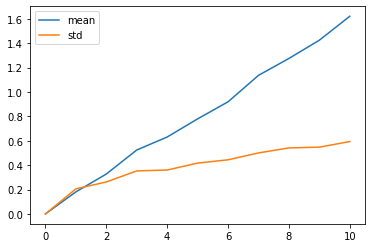

In [99]:
import matplotlib.pyplot as plt
plt.plot(m_list,label="mean")
plt.plot(s_list,label="std")
plt.legend()
plt.savefig("./1_a.png")
plt.show()

# 1.b

In [78]:
e_r = 11*(1/6)
var_r = 11*(7/180)
e_r , var_r

(1.8333333333333333, 0.4277777777777778)

In [30]:
with open("./clean_fake.txt","r") as f :
    fake_text = f.read().splitlines() 
    
with open("./clean_real.txt","r") as f :
    real_text = f.read().splitlines() 
    
label = [0] * len(fake_text) + [1] * len(real_text)
corpus = fake_text + real_text

In [53]:
def load_data(fake_text , real_text) :
    label = np.array([0] * len(fake_text) + [1] * len(real_text)).reshape(-1,1)
    corpus = fake_text + real_text
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    tr_corpus  , va_corpus , tr_label , va_label = train_test_split(X.toarray(), label, train_size= 0.7,shuffle=True)
    va_corpus , te_corpus , va_label , te_label = train_test_split(va_corpus, va_label, train_size= 0.5,shuffle=True)
    col_names = vectorizer.get_feature_names() + ["target_y"]
    train = pd.DataFrame(np.concatenate((tr_corpus,tr_label),axis=1),columns=col_names)
    valid = pd.DataFrame(np.concatenate((va_corpus,va_label),axis=1),columns=col_names)
    test = pd.DataFrame(np.concatenate((te_corpus,te_label),axis=1),columns=col_names)
    return [train, valid, test]

In [54]:
train , valid , test = load_data(fake_text=fake_text,real_text=real_text)

In [55]:

criterion = ["gini","entropy"]
max_depth = range(7,12)
def select_model(train , valid , max_depth_list , criterion_list) :
    trainY = train["target_y"].values
    trainX  =train.drop(["target_y"],axis=1).values
    validY = valid["target_y"].values
    validX  =valid.drop(["target_y"],axis=1).values
    keys = ["max_depth", "criterion", "accuray"]
    result_dict = {k:[] for k in  keys}
    best_model = None 
    best_acc = 0
    for max_depth in max_depth_list :
        for criterion in criterion_list : 
            model = DecisionTreeClassifier(max_depth=max_depth , criterion=criterion)
            model.fit(trainX , trainY)
            valid_pred = model.predict(validX)
            metric = accuracy_score(validY , valid_pred)
            print(f" max_depth : {max_depth} , criterion : {criterion} , accuray : {metric*100}")
            result_dict["max_depth"]=max_depth
            result_dict["criterion"]=criterion
            result_dict["accuray"]=metric
            if best_acc < metric : 
                best_model = model 
                best_acc = metric 
    # pd.DataFrame([result_dict])
    return best_model 
            
best_model = select_model(train ,valid , max_depth , criterion)
    

 max_depth : 7 , criterion : gini , accuray : 70.20408163265306
 max_depth : 7 , criterion : entropy , accuray : 69.59183673469389
 max_depth : 8 , criterion : gini , accuray : 69.79591836734694
 max_depth : 8 , criterion : entropy , accuray : 68.57142857142857
 max_depth : 9 , criterion : gini , accuray : 70.61224489795919
 max_depth : 9 , criterion : entropy , accuray : 69.38775510204081
 max_depth : 10 , criterion : gini , accuray : 72.0408163265306
 max_depth : 10 , criterion : entropy , accuray : 69.38775510204081
 max_depth : 11 , criterion : gini , accuray : 72.85714285714285
 max_depth : 11 , criterion : entropy , accuray : 70.61224489795919


In [65]:
from sklearn import tree
import graphviz
# text_representation = tree.export_text(best_model)
# print(text_representation)

In [70]:
feature_names = [i for i in train.columns.tolist() if i != 'target_y']
target_names = ["fake","real"]

In [71]:

dot_data = tree.export_graphviz(best_model, out_file=None, 
                                max_depth = 2,
                                feature_names=feature_names,  
                                class_names=["fake","real"] ,
                                filled=True)

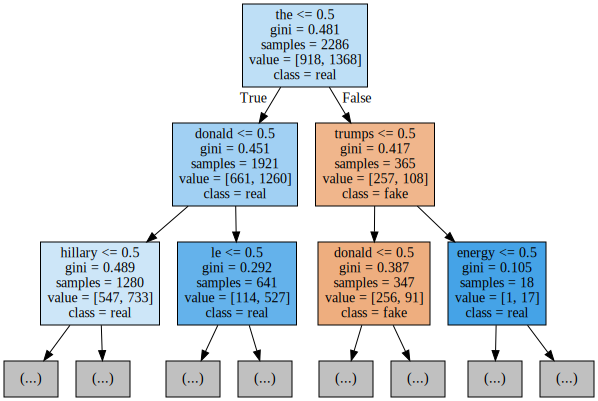

In [72]:
graph = graphviz.Source(dot_data, format="png") 
graph

In [75]:
import math 

def calc_entropy(column):
    counts = np.bincount(column)
    probabilities = counts / len(column)
    entropy = 0
    for prob in probabilities:
        if prob > 0:
            entropy += prob * math.log(prob, 2)
    return -entropy

def compute_information_gain(data, split_name, target_name):
    original_entropy = calc_entropy(data[target_name])
    values = data[split_name].unique()
    left_split = data[data[split_name] == values[0]]
    right_split = data[data[split_name] == values[1]]
    to_subtract = 0
    for subset in [left_split, right_split]:
        prob = (subset.shape[0] / data.shape[0]) 
        to_subtract += prob * calc_entropy(subset[target_name])
    return original_entropy - to_subtract

In [77]:
gain = compute_information_gain(train,"the","target_y")
print("the",gain)
sev_keywords = ["donald","trumps","hillary","le","energy"]
for k in sev_keywords :
    gain = compute_information_gain(train,"the","target_y")
    print(k , gain)
    

the 0.0703674895008437
donald 0.0703674895008437
trumps 0.0703674895008437
hillary 0.0703674895008437
le 0.0703674895008437
energy 0.0703674895008437
